In [3]:
# Cell 1
#!pip install -r ../requirements.txt

In [1]:
# Cell 2
import warnings
warnings.filterwarnings('ignore')

import pandas_plink as pp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import r2_score
import random
import os
import tarfile
import gzip
from extract_data import extract_data
#extract_data()
from tools import *


%load_ext autoreload
%autoreload 2

In [2]:
!./plink2

PLINK v2.0.0-a.6 32-bit (20 Oct 2024)              cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-counts,
--sample-counts, --missing, --hardy, --het, --fst, --indep-pairwise,
--r2-phased, --sample-diff, --make-king, --king-cutoff, --pmerge, --pgen-diff,
--write-samples, --write-snplist, --make-grm-list, --pca, --glm, --adjust-file,
--gwas-ssf, --pheno-svd, --clump, --score-list, --variant-score,
--genotyping-rate, --pgen-info, --validate, and --zst-decompress.

"plink2 --help | more" describes all functions.


In [3]:
# Cell 4
phenotype_data = '../data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz'

# alleles = .bim (snp. came from vcf file (txt file))
# samples = .fam (family id)
# genotypes = .bed (genotypes). Rows and columns defined by alleles and samples
(alleles, samples, genotypes) = pp.read_plink("../data/LDREF/1000G.EUR.*",
                             verbose=False)
genotypes = pd.DataFrame(genotypes.compute())
P = pd.read_csv(phenotype_data, sep='\t', compression='gzip')
P

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000152931.6,ENSG00000152931.6,5,59783540,0.101858,0.078110,0.048981,0.118597,0.004035,0.010925,...,0.088601,0.240010,0.137175,0.148494,0.038643,0.088509,0.029204,0.024423,0.044816,0.139186
1,ENSG00000183696.9,ENSG00000183696.9,7,48128225,8.183805,5.686911,2.434653,3.830894,6.612288,4.709646,...,13.428205,6.094500,12.536000,2.217262,3.573394,7.583364,4.052882,1.570378,4.900372,6.737308
2,ENSG00000139269.2,ENSG00000139269.2,12,57846106,1.199910,1.573572,0.521616,1.447225,3.565791,1.982681,...,3.225880,1.996067,2.854923,2.267343,1.331201,2.187895,1.004250,3.003316,1.984362,1.684954
3,ENSG00000169129.8,ENSG00000169129.8,10,116164515,0.831940,0.069778,0.931086,0.620941,1.660668,0.570481,...,1.023381,1.127852,0.774409,1.495854,0.895342,1.513521,0.826377,1.021201,0.952502,0.740565
4,ENSG00000134602.11,ENSG00000134602.11,X,131157293,27.646422,24.395572,16.445374,24.806650,25.113349,19.233988,...,25.079490,28.725528,24.450520,27.264069,26.912814,29.509210,26.462331,25.624009,25.707741,22.824957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23717,ENSG00000235472.1,ENSG00000235472.1,13,29172970,31.582832,34.071123,19.394365,37.523721,33.430473,37.844966,...,47.905182,33.224977,39.827675,27.096811,34.686342,37.386766,30.598840,33.516674,32.017940,38.341888
23718,ENSG00000114423.14,ENSG00000114423.14,3,105588396,14.054749,14.477899,11.584425,12.637956,12.015089,13.750655,...,11.723462,9.900372,10.473115,13.433413,15.832594,19.216176,10.213739,14.563192,15.637732,8.357117
23719,ENSG00000243312.2,ENSG00000243312.2,4,87791344,1.112114,0.831797,0.253228,0.271568,0.486086,1.362640,...,1.168991,0.645389,0.819469,0.515448,0.463054,1.580658,0.701396,0.771233,0.857330,0.703369
23720,ENSG00000257337.1,ENSG00000257337.1,12,53448222,3.826396,6.045798,2.593872,4.447169,5.294657,4.106823,...,6.524398,6.017795,3.460273,3.905032,5.023161,5.333027,5.694370,8.142939,5.622043,6.026476


In [4]:
# Cell 6
# eQTL analysis for all genes on a chromosome
chr_22_analysis = chr_analysis('22', alleles, samples, genotypes, P)
chr_22_analysis


Starting cis-eQTL analyses for chromosome 22
0/633 analyses completed
100/633 analyses completed
200/633 analyses completed
300/633 analyses completed
400/633 analyses completed
500/633 analyses completed
600/633 analyses completed
Compiling results


,snp,chr,bp,p,se,beta,a0,a1,i
0,rs7287144,22,16886873,0.491937,0.687972,0.009765,G,A,677742
1,rs5748662,22,16892858,0.280728,1.080395,0.014794,A,G,677743
2,rs5994034,22,16894090,0.513451,-0.654156,-0.013121,T,C,677744
3,rs4010554,22,16894264,0.254629,1.141094,0.015812,A,C,677745
4,rs4010558,22,16896762,0.254629,1.141094,0.015812,A,G,677746
...,...,...,...,...,...,...,...,...,...
270884,rs9606716,22,30728453,0.289423,1.061035,2.089229,A,G,684283
270885,rs2839998,22,30729507,0.427095,-0.795120,-0.505301,A,G,684284
270886,rs11705056,22,30730745,0.529255,-0.629786,-0.525327,T,C,684285
270887,rs2240420,22,30731066,0.951560,-0.060792,-0.036132,C,T,684286


In [13]:
chr_22_num_snps = alleles[alleles['chrom']=='22'].shape[0]
chr_22_num_genes = P[P['Chr']=='22'].shape[0]
chr_22_snp_gene_pairs = chr_22_num_snps * chr_22_num_genes
chr_22_snp_gene_pairs, chr_22_num_snps, chr_22_num_genes

(11070537, 17489, 633)

In [14]:
chr_22_num_sig_cis_eqtls = chr_22_analysis[chr_22_analysis['p'] < 0.05 / chr_22_snp_gene_pairs].shape[0]
chr_22_num_sig_cis_eqtls

1000

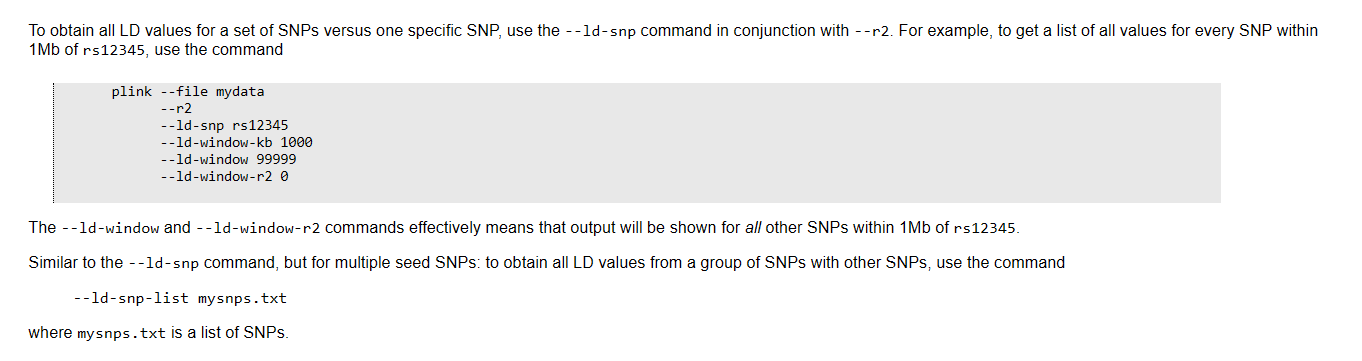

In [59]:
target_gene = 'ENSG00000099998.12'
target_chr = '22'
temp_analysis = cis_eQTL_analysis(target_chr, target_gene, alleles, samples, genotypes, P)
temp_analysis

,snp,chr,bp,p,se,beta,a0,a1,i
0,rs738796,22,24142523,0.157596,-1.416307,-0.011499,T,C,680799
1,rs17003912,22,24145809,0.576344,0.559269,0.003362,C,T,680800
2,rs9620326,22,24146629,0.552155,0.595123,0.003046,T,C,680801
3,rs11912715,22,24147595,0.576344,0.559269,0.003362,C,T,680802
4,rs2267032,22,24148273,0.830617,-0.214074,-0.001080,A,G,680803
...,...,...,...,...,...,...,...,...,...
353,rs8139987,22,25131425,0.537624,-0.617032,-0.002991,T,G,681152
354,rs5751963,22,25132498,0.391766,-0.857506,-0.003226,G,A,681153
355,rs5760614,22,25132558,0.391766,-0.857506,-0.003226,T,C,681154
356,rs2096533,22,25133052,0.418495,0.810015,0.003094,G,T,681155


In [71]:
ref_snp = temp_analysis[temp_analysis['p'] == temp_analysis['p'].min()]
ref_snp_id = ref_snp['snp'].iloc[0]
ref_snp_id

'rs5760273'

In [72]:
snp_file = get_snps(target_gene, P, out_dir='week6_out/')


In [73]:
plink_ld_cmd = f'./plink --bfile {snp_file} --r2 --ld-snp {ref_snp_id} --ld-window-kb 1000 --ld-window 99999 --ld-window-r2 0 --out {snp_file}'
os.system(plink_ld_cmd)

PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to week6_out/1000G.EUR.22.ENSG00000099998.12.log.
Options in effect:
  --bfile week6_out/1000G.EUR.22.ENSG00000099998.12
  --ld-snp rs5760273
  --ld-window 99999
  --ld-window-kb 1000
  --ld-window-r2 0
  --out week6_out/1000G.EUR.22.ENSG00000099998.12
  --r2

257649 MB RAM detected; reserving 128824 MB for main workspace.
358 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to week6_out/1000G.EUR.22.ENSG00000099998.12.nosex .
Using up to 127 threads (change this with --threads).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%

0

In [75]:
target_gene_ld_df = pd.read_csv(snp_file+'.ld', delim_whitespace=True)

target_gene_ld_df

,CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R2
0,22,24636822,rs5760273,22,24142523,rs738796,0.000145
1,22,24636822,rs5760273,22,24145809,rs17003912,0.005048
2,22,24636822,rs5760273,22,24146629,rs9620326,0.000344
3,22,24636822,rs5760273,22,24147595,rs11912715,0.005048
4,22,24636822,rs5760273,22,24148273,rs2267032,0.008093
...,...,...,...,...,...,...,...
353,22,24636822,rs5760273,22,25131425,rs8139987,0.000754
354,22,24636822,rs5760273,22,25132498,rs5751963,0.000034
355,22,24636822,rs5760273,22,25132558,rs5760614,0.000034
356,22,24636822,rs5760273,22,25133052,rs2096533,0.001189


In [76]:
# r2 > 0.8

target_gene_ld_df[target_gene_ld_df['R2'] > 0.8].shape[0]

2

In [77]:
# r2 > 0.5

target_gene_ld_df[target_gene_ld_df['R2'] > 0.5].shape[0]

13

In [78]:
# r2 > 0.1

target_gene_ld_df[target_gene_ld_df['R2'] > 0.1].shape[0]

79

In [79]:
temp_analysis.to_csv('week6_out/locus_data.txt', sep='\t', index=False)

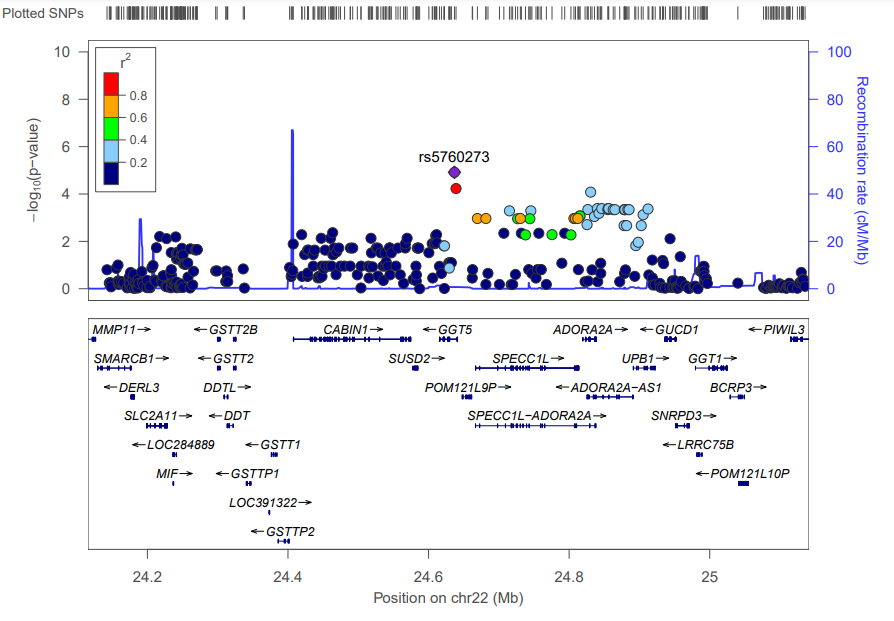